# Recitation 5

## Least Squares

Suppose we have a scattered set of $(x,y)$ points, and we want to draw a line of best fit for them. We can use least squares to do this pretty easily.

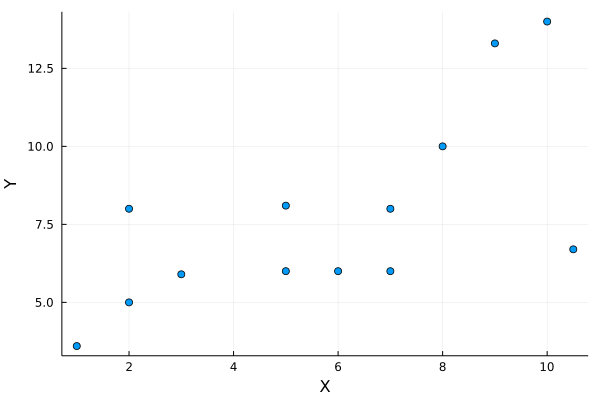

In [1]:
using Plots, LinearAlgebra
gr()

# data
x_data = [1, 2, 3, 2, 6, 7, 10.5, 5, 5, 8, 7, 9, 10]
y_data = [3.6, 5, 5.9, 8, 6, 8, 6.7, 6, 8.1, 10, 6, 13.3, 14]

# plot data
scatter(x_data, y_data)
plot!(xlabel="X", ylabel="Y", leg=false)

In a least squares problem, we are trying to find the best solution to $Ax=b$, where "best" means the solution provides the least squared error, i.e $\|Ax-b\|$ is minimized. In this case we can't solve $Ax=b$ normally, since our dataset clearly has no exact solution (you can't draw a single straight line that goes through every point).

To find the solution with least squared error, we first need to set up the problem in the correct form. We should put our $x$ values in a column of our $A$ matrix and our $y$ values in our $b$ vector, since we are trying to find a relation between the x and y values. If this is all we did, we would only have a single variable to change in order to find the best fit line, which would correspond to our line's slope. This would make our best fit very innacurate if any offset from the origin was needed.

To account for this, we need to add a second column to our $A$ matrix, which will just be ones. this will provide an offset for our best fit line.

In [23]:
A = [x_data ones(size(x_data))]

13×2 Matrix{Float64}:
  1.0  1.0
  2.0  1.0
  3.0  1.0
  2.0  1.0
  6.0  1.0
  7.0  1.0
 10.5  1.0
  5.0  1.0
  5.0  1.0
  8.0  1.0
  7.0  1.0
  9.0  1.0
 10.0  1.0

We will solve our least squares problem by first multiplying both sides of our equation by $A^T$, giving us $A^TAx=A^Tb$, then solving the equation.

In [36]:
# setup equation
b = y_data
A_T = A'
A_T_A = A_T * A
A_T_b = A_T * b

# empty x vector to put solution in
x = [0, 0]

2-element Vector{Int64}:
 0
 0

First, try solving with LU factorization. Don't forget to take permutations into account!

In [38]:
# Given forward and backward substitution functions
function forwardsub(L, b)
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    # START of our computations
    n = length(b)
    x = Vector{Float64}(undef, n); #initialize an x vector of the correct size
    x[1] = b[1]/L[1,1] #find the first entry of x
    for i = 2:n #find every entry from the 2nd to the end
        x[i]=(b[i]- (L[i,1:i-1])'*x[1:i-1] )/L[i,i] 
        #notice that we used the transpose operator to get the row of L
    end
    # END of our computations. 
    return x
end

function backwardsub(U, b)
    
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    
    n = length(b)
    x = Vector{Float64}(undef, n)

    x[n] = b[n] / U[n,n]
    for i in n-1:-1:1
        x[i]=(b[i] - (U[i,(i+1):n])' * x[(i+1):n]) ./ U[i,i]
    end
    
    return x    
end

backwardsub (generic function with 1 method)

In [ ]:
# solve A_T_A * x = A_T_b
F = lu(A_T_A)
L = F.L
U = F.U
P = F.P

# Your solution here


2-element Array{Float64,1}:
 0.6533354922279799
 3.9440900259067315

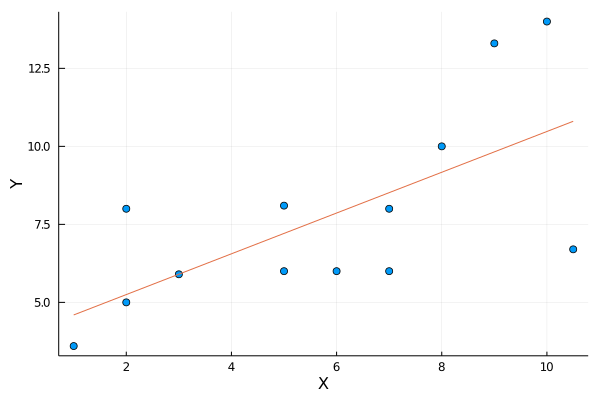

In [ ]:
# plot best fit line
m = x[1]
b = x[2]
x_line = [1, 10.5]
y_line = m * x_line .+ b
scatter(x_data, y_data)
plot!(xlabel="X", ylabel="Y", leg=false)
plot!(x_line, y_line)

## QR Factorization and Gram-Schmidt

We can also solve the problem above using QR factorization.

<img src = "https://i.postimg.cc/hGLpSYG9/QR.jpg" width = "800" >

 Recall that in QR factorization we find the orhtonormal matrix $Q$ and the upper triangular matrix $R$ such that $A=QR$. Using the QR factorization, we now have:<br>
$\begin{align*}
     A^TAx&=A^Tb\\
     A^TA&=R^TQ^TQR=R^TR\\
     A^Tb&=R^TQ^Tb\\
     R^TRx&=R^TQ^Tb \rightarrow Rx=Q^Tb
\end{align*}$

Since $R$ is an upper triangular matrix, we can use back substitution to solve for x

To find $Q$, we use Gram Schmidt.The Gram Schmidt process is as follows:
\begin{align*}
        v_1 &= u_1\\
        v_2 &= u_2-\left( \frac{u_2\cdot v_1}{v_1\cdot v_1} \right)v_1\\
        v_3 &= u_3-\left( \frac{u_3\cdot v_1}{v_1\cdot v_1} \right)v_1-\left( \frac{u_3\cdot v_2}{v_2\cdot v_2} \right)v_2\\
        &\vdots\\
        v_k &= u_k-\sum_{i=1}^{k-1} \left(\frac{u_k\cdot v_i}{v_i\cdot v_i} \right)v_i\\
    \end{align*}

In words, given a matrix $A$ with linearly independent columns$\{u_1,u_2,...,u_m\}$, Gram Schmidt finds a set of orthogonal vectors $\{v_1,v_2,...,v_m\}$. From this $Q := \left[\frac{v_1}{||v_1||}\frac{v_2}{||v_2||}\ldots\frac{v_m}{||v_m||}\right]=\{q_1, ...,q_m\}$. Because $Q^TQ = I_m$, it follows that $A = Q \cdot R \leftrightarrow R = Q^T A.$

Let's take a look at how we would write a function that computes Q using the Gram Schmidt process. If we let $S=\sum_{i=1}^{k-1} \left(\frac{u_k\cdot v_i}{v_i\cdot v_i} \right)v_i$, the pseudo code is as follows: <br>
For k=1:m <br>
    &emsp;$u_k$= $A_k$ <br>
    &emsp;For $j$=1:$k$-1 <br>
        &emsp; &emsp; $v_k$=uk-S <br>
    &emsp;end <br>
    &emsp;$q_k$=$\frac{v_k}{||v_k||}$ <br>
   end

In [19]:

function gramSchmidt(A)
    r,c=size(A)
    v=zeros(r,c)
    vNorm=zeros(r,c)
    for k=1:c
        S=zeros(r,1)
        uk=A[:,k]
        for j =1:k-1
            vj=v[:,j]
            S=(dot(vj,uk)/dot(vj,vj))*vj+S
        end
        v[:,k]=uk-S
        vNorm[:,k]=v[:,k]/norm(v[:,k])
    end
    return v, vNorm
end


4×3 Matrix{Float64}:
 0.0776151   0.833052   0.80649
 0.31046     0.451237   0.50058
 0.543305    0.069421   0.22248
 0.776151   -0.312395  -0.22248

3×3 Matrix{Float64}:
 12.8841       14.5916   16.2992
 -1.19904e-14   1.04132   2.08263
  2.14137       3.44844   4.75551

Now that we have our Gram Schmidt function, let's use it to find Q. Recall we are trying to solve $A^TAx=A^Tb$. <br>
Before using the Gram Schmidt function, we need to check to see if $A$ has linearly independent columns.

In [27]:
#check if A has linearly independent columns

#your solution here



Next use the gramSchmidt function to find Q and then using that find R. Finally solve for x using back substitution

In [31]:
#Find the Q matrix
v,Q=gramSchmidt(A)
display(Q)



13×2 Matrix{Float64}:
 0.0423619   0.519365
 0.0847237   0.43797
 0.127086    0.356575
 0.0847237   0.43797
 0.254171    0.11239
 0.296533    0.0309948
 0.444799   -0.253888
 0.211809    0.193785
 0.211809    0.193785
 0.338895   -0.0504003
 0.296533    0.0309948
 0.381257   -0.131795
 0.423619   -0.21319

In [33]:
#checking to see if Q is orthonormal
display(Q'*Q)



2×2 Matrix{Float64}:
 1.0          3.66067e-17
 3.66067e-17  1.0

In [34]:
#Find R
R=  #your solution here
display(R)



2×2 Matrix{Float64}:
 23.6061       3.19832
  1.44329e-15  1.66456

In [40]:
#Find x using backsubstitution
x_qr=backwardsub()

2-element Vector{Float64}:
 0.6533354922279794
 3.9440900259067364

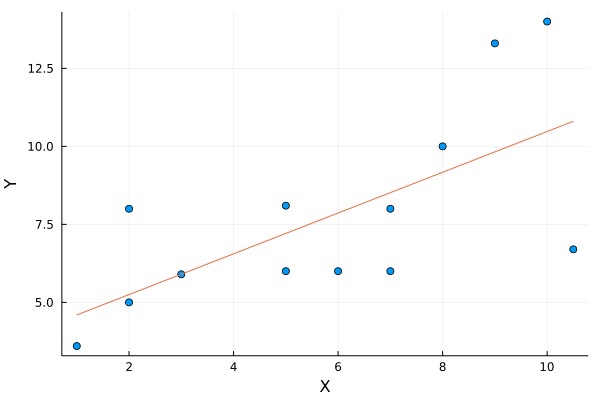

In [42]:
# plot best fit line
m = x[1]
b = x[2]
m_qr=x_qr[1]
b_qr=x_qr[2]
x_line = [1, 10.5]
y_line = m * x_line .+ b
yqr_line=m_qr * x_line .+ b_qr
scatter(x_data, y_data)
plot!(xlabel="X", ylabel="Y", leg=false)
plot!(x_line, y_line)
plot!(x_line, yqr_line)